## Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})
%matplotlib inline
sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("whitegrid")
plt.style.use('seaborn-pastel')

In [2]:
from scipy.fft import fft, fftfreq, fftshift

In [3]:
from scipy import signal
from scipy.integrate import cumtrapz

In [4]:
from buoy_methods import *

## Wave Modeling

### Types of Waves and Characteristics

### Deep vs Shallow

### Data Segmenting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       1024 non-null   float64
 1   Ax      1024 non-null   float64
 2   Ay      1024 non-null   float64
 3   Az      1024 non-null   float64
 4   wx      1024 non-null   float64
 5   wy      1024 non-null   float64
 6   wz      1024 non-null   float64
 7   Bx      1024 non-null   float64
 8   By      1024 non-null   float64
 9   Bz      1024 non-null   float64
 10  qw      1024 non-null   float64
 11  qx      1024 non-null   float64
 12  qy      1024 non-null   float64
 13  qz      1024 non-null   float64
dtypes: float64(14)
memory usage: 112.1 KB
None


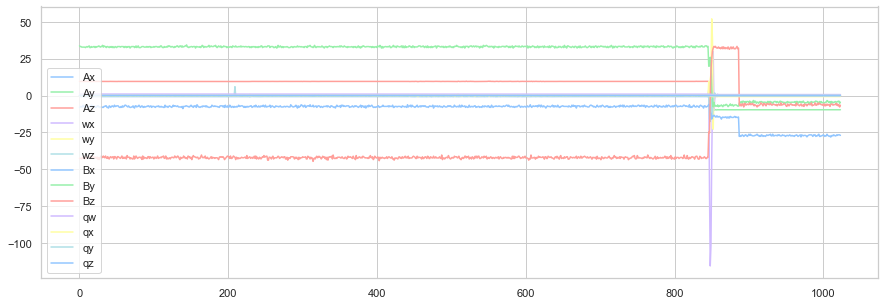

In [5]:
df  =  pd.read_csv("data/first quaternion data.csv")
#print(df.head())
print(df.info())
df.drop('t',axis=1).plot()

### Mean Removal and Smoothing

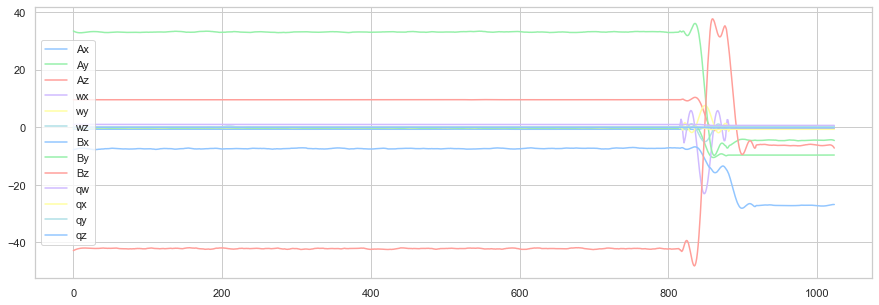

In [6]:
i=1
while i:
    try:
        df = df.apply(signal.savgol_filter, args=(63,6)) #x, window_length, polyorder,
    except:
        continue
    i=0
df.drop('t',axis=1).plot()

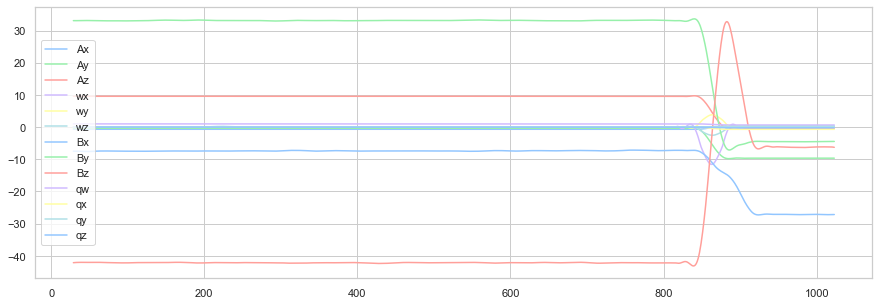

In [7]:
df = df.rolling(30).mean()
df.drop('t',axis=1).plot()

In [8]:
df.dropna(inplace=True)
acc = df.iloc[:,1:4].to_numpy()
gyr = df.iloc[:,4:7].to_numpy()
mag = df.iloc[:,7:10].to_numpy()

### Direction Definitions

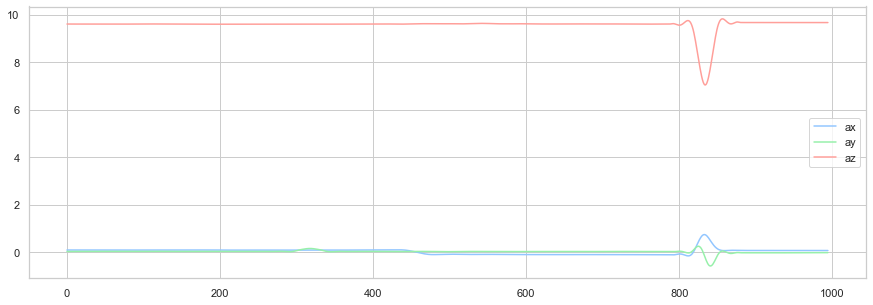

In [9]:
quate = []
for i in range(len(df.qx)):
    quate.append(Quaternion([df.qw.iloc[i],df.qx.iloc[i],df.qy.iloc[i],df.qz.iloc[i]]))
a=[]
for i, q in enumerate(quate):
    a.append(q.rotate_vector(acc[i]))
al = pd.DataFrame(a,columns=['ax','ay','az'])
al.plot()

In [10]:
al.az[0:600].mean()

9.607365012993924

In [11]:
al.ax[0:600].mean()

0.04715730233132825

In [12]:
adj = al.copy()
adj.az += -al.az[0:600].mean()
#adj.ax -= al.ax[0:600].mean()

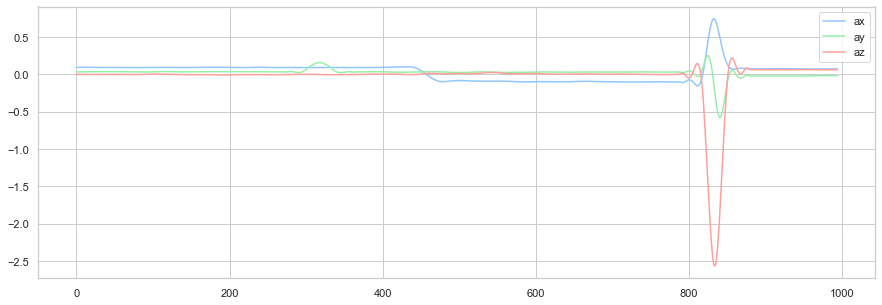

In [13]:
adj.plot()

### Integration

In [14]:
dt = np.round(df.t.diff().mean(),decimals=2)*0.001
dt #seconds

0.32974000000000003

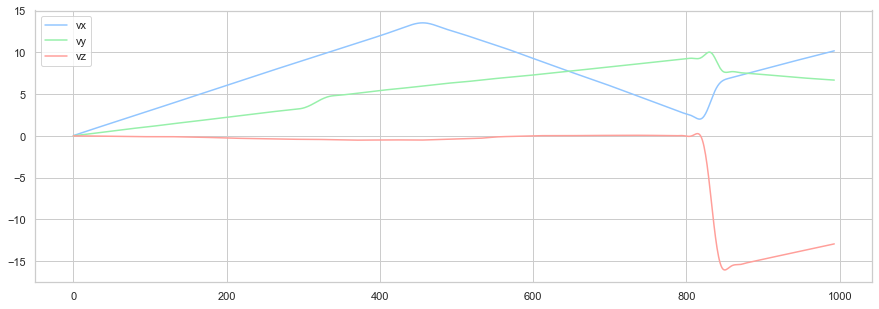

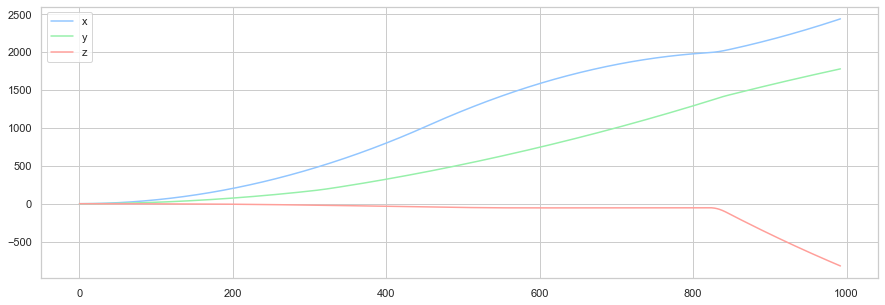

In [15]:
vx = cumtrapz(adj.iloc[:, 0], dx=dt)
vy = cumtrapz(adj.iloc[:, 1], dx=dt)
vz = cumtrapz(adj.iloc[:, 2], dx=dt)
fig, ax = plt.subplots()
ax.plot(vx, label='vx')
ax.plot(vy, label='vy')
ax.plot(vz, label='vz')
ax.legend()
x = cumtrapz(vx, dx=dt)
y = cumtrapz(vy, dx=dt)
z = cumtrapz(vz, dx=dt)
position = pd.DataFrame([x, y, z]).T
position.columns= ['x','y','z']
position.plot()

### Sea State

## Frequency and Direction Analysis

### Modeling

### FFT

In [16]:
Fx = fftshift(fft(adj.ax.values))
Fy = fftshift(fft(adj.ay.values))
Fz = fftshift(fft(adj.az.values))
freq = fftshift(fftfreq(df.t.shape[-1],d=dt)) # Hz

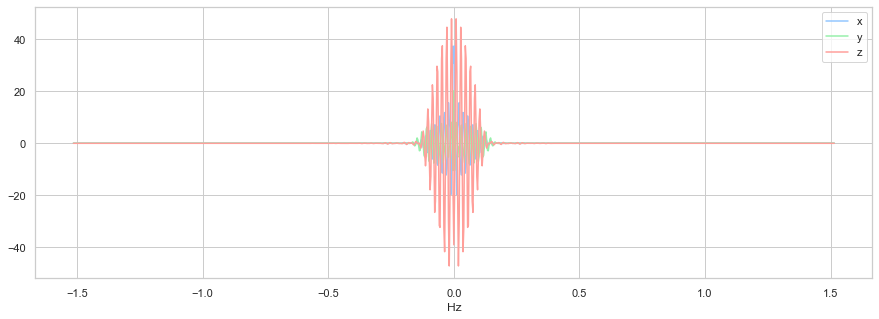

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel('Hz')
ax.plot(freq, Fx.real, label='x')
ax.plot(freq, Fy.real, label='y')
ax.plot(freq, Fz.real, label='z')
ax.legend()
plt.show()

### Cross Spectral Analysis

$$co-spectra\ =\ A_{xk} A_{yk} +B_{xk} B_{yk}$$

In [18]:
def co_spectrum(A1, A2):
    return A1.real * A2.real + A1.imag * A2.imag
def quad_spectrum(A1, A2):
    return A1.real * A2.imag - A1.imag * A2.real

In [19]:
A = [Fx, Fy, Fz]

In [20]:
C = pd.DataFrame()
Q = pd.DataFrame()
coords = ['x', 'y', 'z']
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        C[coords[i] + coords[j]] = co_spectrum(A[i], A[j])
    # print(C.info())
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        Q[coords[i] + coords[j]] = quad_spectrum(A[i], A[j])

    # These are not used for waves. These describe eddies
Q['xy'] = 0.0
Q['yx'] = 0.0

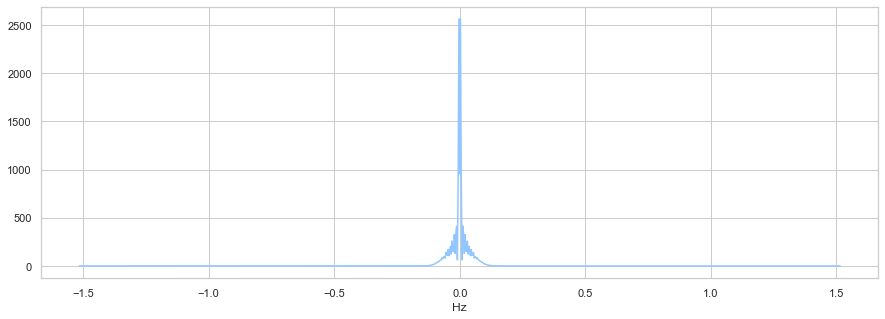

In [21]:
fig, ax = plt.subplots()
ax.set_xlabel('Hz')
ax.plot(freq, C.xx)

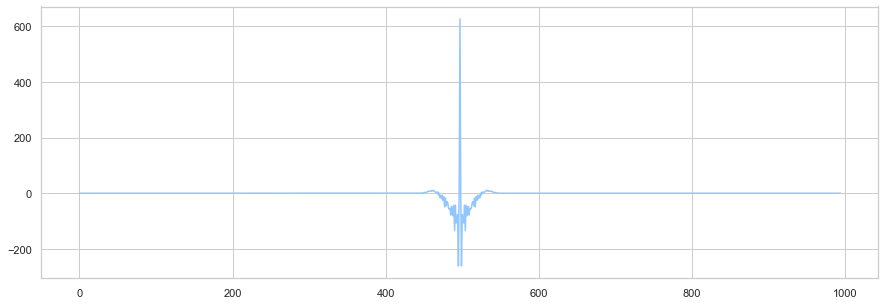

In [22]:
plt.plot(C.xy)

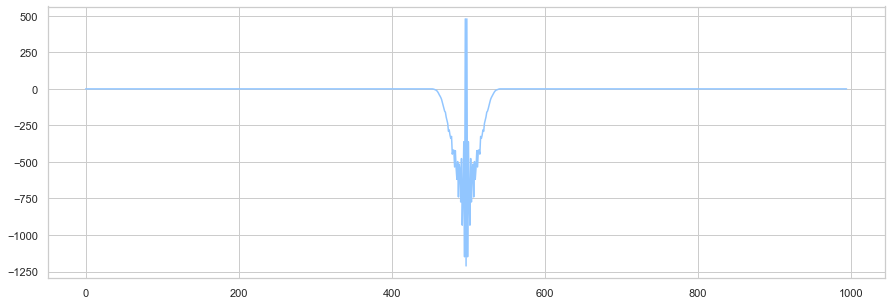

In [23]:
plt.plot(C.xz)

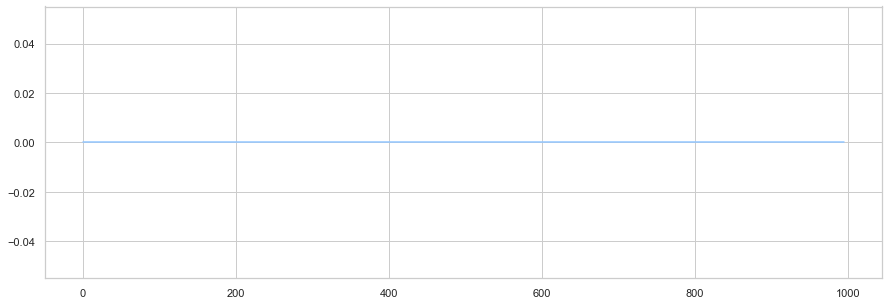

In [24]:
plt.plot(Q.xy)

### Circular Moments and Directional Distribution

### Mean, Width, Skewness and Kurtosis